# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
#<a href=http://www.datascience-paris-saclay.fr/en/site/newsView/12>RAMP</a> on El Nino prediction

<i> Balázs Kégl (CNRS), Claire Monteleoni (GWU), Mahesh Mohan (GWU), Timothy DelSole (COLA), Kathleen Pegion (COLA), Julie Leloup (UPMC), Alex Gramfort (LTCI) </i>

## Introduction

A climate index is real-valued time-series which has been designated of interest in the climate literature. For example, the El Niño–Southern Oscillation (ENSO) index has widespread uses for predictions of regional and seasonal conditions, as it tends to have strong (positive or negative) correlation with a variety of weather conditions and <a href=http://www.ipcc-wg2.gov/SREX/images/uploads/SREX-SPMbrochure_FINAL.pdf>extreme events</a> throughout the globe. The ENSO index is just one of the many climate indices studied. However there is currently significant room for improvement in predicting even this extremely well studied index with such high global impact. For example, most statistical and climatological models erred significantly in their predictions of the 2015 El Niño event; their predictions were off by several months. Better tools to predict such indices are critical for seasonal and regional climate prediction, and would thus address grand challenges in the study of climate change (<a href=http://wcrp-climate.org/grand-challenges>World Climate Research Programme: Grand Challenges, 2013)</a>.

### El Niño

<a href="https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst.php">El Niño</a> (La Niña) is a phenomenon in the equatorial Pacific Ocean characterized by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the <a href=http://www1.ncdc.noaa.gov/pub/data/cmb/teleconnections/nino-regions.gif>Niño 3.4 region</a> that is above (below) the threshold of $+0.5^\circ$C ($-0.5\circ$C). This standard of measure is known as the Oceanic Niño Index (ONI).

<img src=http://www1.ncdc.noaa.gov/pub/data/cmb/teleconnections/nino-regions.gif>

Mor information can be found <a href=https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst.php>here</a> on why it is an important region, and what is the history of the index.

Here are the <a href = http://iri.columbia.edu/our-expertise/climate/forecasts/enso/current/>current ENSO predictions</a>, updated monthly.


### The CCSM4 simulator

Our data is coming from the <a href=http://www.cesm.ucar.edu/models/ccsm4.0/>CCSM4.0</a> model (simulator). This allows us to access a full regular temperature map for a 500+ year period which makes the evaluation of the predictor more robust than if we used real measurements. 

### The data

The data is a time series of "images" $z_t$, consisting of temperature measurements (for a technical reason it is not SST that we will work with, rather air temperature) on a regular grid on the Earth, indexed by lon(gitude) and lat(itude) coordinates. The average temperatures are recorded every month for 501 years, giving 6012 time points. The goal is to predict the temperature in the El Nino region, <span style="color:red">6 months ahead</span>.

### The prediction task

Similarly to the variable stars RAMP, the pipeline will consists of a feature extractor and a predictor. Since the task is regression, the predictor will be a regressor, and the score (to minimize) will be the <a href=http://en.wikipedia.org/wiki/Root-mean-square_deviation>root mean square error</a>. The feature extractor will have access to the whole data. It will construct a "classical" feature matrix where each row corresponds to a time point. You should collect all information into these features that you find relevant to the regressor. The feature extractor can take <span style="color:red">anything from the past</span>, that is, it will implement a function $x_t = f(z_1, \ldots, z_t)$. Since you will have access to the full data, in theory you can cheat (even inadvertantly) by using information from the future. Please do your best to avoid this since it would make the results irrelevant.

### Domain-knowledge suggestions

You are of course free to explore any regression technique to improve the prediction. Since the input dimension is relatively large (2000+ dimensions per time point even after subsampling) sparse regression techniques (eg. LASSO) may be the best way to go, but this is just an a priori suggestion. The following list provides you other hints to start with, based on domain knowledge. 
<ul>
<li>There is a strong seasonal cycle that must be taken into account.
<li>There is little scientific/observational evidence that regions outside the Pacific play a role in NINO3.4 variability, so it is probably best to focus on Pacific SST for predictions.  
<li>The relation between tropical and extra-tropical Pacific SST is very unclear, so please explore!
<li>The NINO3.4 index has an oscillatory character (cold followed by warm followed by cold), but this pattern does not repeat exactly.  It would be useful to be able to predict periods when the oscillation is “strong” and when it “breaks down.”  
<li>A common shortcoming of empirical predictions is that they under-predict the <i>amplitude</i> of warm and cold events.  Can this be improved?
<li>There is evidence that the predictability is low when forecasts start in, or cross over, March and April (the so-called “spring barrier”). Improving predictions through the spring barrier would be important.
<ul>

# Exploratory data analysis

Packages to install:

conda install basemap<BR>
conda install -c https://conda.binstar.org/anaconda xray<BR>
conda install netcdf4 h5py<BR>
pip install pyresample<BR>

In [1]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xray # should be installed with pip
import pyresample  # should be installed with pip
from sklearn.cross_validation import cross_val_score

ImportError: No module named basemap

Let's start by reading the data into an xray Dataset object. You can find all information on how to access and manipulate <code>Dataset</code> and <code>DataArray</code> objects at the <a href=http://xray.readthedocs.org/en/stable/>xray site</a>.

In [2]:
temperatures_xray = xray.open_dataset(
    'COLA_data/tas_Amon_CCSM4_piControl_r1i1p1_080001-130012.nc', decode_times=False)
#temperatures_xray = xray.open_dataset(
#    'COLA_data/tas_Amon_CCSM4_piControl_r2i1p1_095301-110812.nc', decode_times=False)
#temperatures_xray = xray.open_dataset(
#    'COLA_data/tas_Amon_CCSM4_piControl_r3i1p1_000101-012012.nc', decode_times=False)

# there is no way to convert a date starting with the year 800 into pd array so we 
# shift the starting date to 1700
temperatures_xray['time'] = pd.date_range('1/1/1700', 
                                          periods=temperatures_xray['time'].shape[0],
                                          freq='M') - np.timedelta64(15, 'D')

Printing it, you can see that it contains all the data, indices, and other metadata.

In [3]:
temperatures_xray

<xray.Dataset>
Dimensions:    (bnds: 2, lat: 192, lon: 288, time: 6012)
Coordinates:
  * time       (time) datetime64[ns] 1700-01-16 1700-02-13 1700-03-16 ...
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
    height     float64 2.0
  * bnds       (bnds) int64 0 1
Data variables:
    time_bnds  (time, bnds) float64 2.916e+05 2.917e+05 2.917e+05 2.917e+05 ...
    lat_bnds   (lat, bnds) float64 -90.0 -89.53 -89.53 -88.59 -88.59 -87.64 ...
    lon_bnds   (lon, bnds) float64 -0.625 0.625 0.625 1.875 1.875 3.125 ...
    tas        (time, lat, lon) float64 244.5 244.4 244.6 244.3 244.6 244.4 ...
Attributes:
    institution: NCAR (National Center for Atmospheric Research) Boulder, CO, USA
    institute_id: NCAR
    experiment_id: piControl
    source: CCSM4
    model_id: CCSM4
    forcing: Sl GHG SS Ds SD BC MD OC Oz AA (all fixed at 1850 values)
    parent_experiment_id: N/A
    

The main data is in the 'tas' ("temperature at surface") DataArray.

In [4]:
temperatures_xray['tas']

<xray.DataArray 'tas' (time: 6012, lat: 192, lon: 288)>
[332439552 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1700-01-16 1700-02-13 1700-03-16 ...
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
    height   float64 2.0
Attributes:
    standard_name: air_temperature
    long_name: Near-Surface Air Temperature
    units: K
    original_name: TREFHT
    comment: TREFHT no change
    cell_methods: time: mean (interval: 30 days)
    cell_measures: area: areacella
    history: 2011-12-01T23:41:11Z altered by CMOR: Treated scalar dimension: 'height'. 2011-12-01T23:41:11Z altered by CMOR: Reordered dimensions, original order: lat lon time. 2011-12-01T23:41:11Z altered by CMOR: replaced missing value flag (-1e+32) with standard missing value (1e+20).
    associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_

You can index it in the same way as a <code>pandas</code> or <code>numpy</code> array. The result is always a <coda>DataArray</code>

In [5]:
t = 123
lat = 13
lon = 29
temperatures_xray['tas'][t]
temperatures_xray['tas'][t, lat]
temperatures_xray['tas'][t, lat, lon]
temperatures_xray['tas'][:, lat, lon]
temperatures_xray['tas'][t, :, lon]
temperatures_xray['tas'][:, :, lon]

<xray.DataArray 'tas' (time: 6012, lat: 192)>
[1154304 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1700-01-16 1700-02-13 1700-03-16 ...
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
    lon      float64 36.25
    height   float64 2.0
Attributes:
    standard_name: air_temperature
    long_name: Near-Surface Air Temperature
    units: K
    original_name: TREFHT
    comment: TREFHT no change
    cell_methods: time: mean (interval: 30 days)
    cell_measures: area: areacella
    history: 2011-12-01T23:41:11Z altered by CMOR: Treated scalar dimension: 'height'. 2011-12-01T23:41:11Z altered by CMOR: Reordered dimensions, original order: lat lon time. 2011-12-01T23:41:11Z altered by CMOR: replaced missing value flag (-1e+32) with standard missing value (1e+20).
    associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_CCSM4_piControl_r0i0p0.nc areacella: areacella_fx_CCSM4_piCo

You can convert any of these objects into a <code>numpy</code> array.

In [6]:
temperatures_xray['tas'].values
temperatures_xray['tas'][t].values
temperatures_xray['tas'][t, lat].values
temperatures_xray['tas'][t, lat, lon].values

array(213.9378204345703)

You can also use slices, and slice bounds don't even have to be in the index arrays. The following function computes the target at time $t$. The input is an xray DataArray (3D panel) that contains the temperatures. We select the El Nino 3.4 region, and take the mean temperatures, specifying that we are taking the mean over the spatial (lat and lon) coordinates. The output is a vector with the same length as the original time series.

In [7]:
en_lat_bottom = -5
en_lat_top = 5
en_lon_left = 360 - 170
en_lon_right = 360 - 120

def get_area_mean(tas, lat_bottom, lat_top, lon_left, lon_right):
    """The array of mean temperatures in a region at all time points."""
    return tas.loc[:, lat_bottom:lat_top, lon_left:lon_right].mean(dim=('lat','lon'))

def get_enso_mean(tas):
    """The array of mean temperatures in the El Nino 3.4 region at all time points."""
    return get_area_mean(tas, en_lat_bottom, en_lat_top, en_lon_left, en_lon_right)

The following function plots the temperatures at a given $t$ (time_index). 

In [8]:
el_nino_lats = [en_lat_bottom, en_lat_top, en_lat_top, en_lat_bottom]
el_nino_lons = [en_lon_right, en_lon_right, en_lon_left, en_lon_left]

from matplotlib.patches import Polygon

def plot_map(temperatures_xray, time_index):
    def draw_screen_poly(lats, lons, m):
        x, y = m(lons, lats)
        xy = zip(x,y)
        poly = Polygon(xy, edgecolor='black', fill=False)
        plt.gca().add_patch(poly)

    lons, lats = np.meshgrid(temperatures_xray['lon'], temperatures_xray['lat'])

    fig = plt.figure()
    ax = fig.add_axes([0.05, 0.05, 0.9,0.9])
    map = Basemap(llcrnrlon=0, llcrnrlat=-89, urcrnrlon=360, urcrnrlat=89, projection='mill')
    # draw coastlines, country boundaries, fill continents.
    map.drawcoastlines(linewidth=0.25)
    #map.drawcountries(linewidth=0.25)
    #map.fillcontinents(color='coral',lake_color='aqua')
    # draw the edge of the map projection region (the projection limb)
    #map.drawmapboundary(fill_color='aqua')
    im = map.pcolormesh(lons, lats, temperatures_xray[time_index] - 273.15,
                        shading='flat', cmap=plt.cm.jet, latlon=True)
    cb = map.colorbar(im,"bottom", size="5%", pad="2%")
    draw_screen_poly(el_nino_lats, el_nino_lons, map)

    time_str = str(pd.to_datetime(str(temperatures_xray['time'].values[time_index])))[:7]
    ax.set_title("Temperature map " + time_str)
    #plt.savefig("test_plot.pdf")
    plt.show()

Let's plot the temperature at a given time point. Feel free to change the time, play with the season, discover visually the variability of the temperature map.

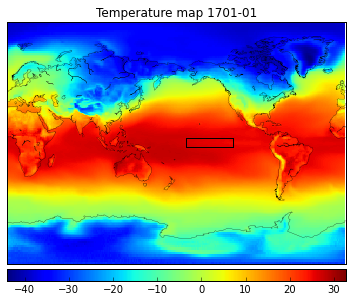

In [9]:
t = 12
plot_map(temperatures_xray['tas'], t)

##The target

The first order variation of the temperature comes from its regular yearly fluctuation. Climate scientist usually look at the temperture <i>anomaly</i>, not the raw temperature itself. More precisely, they subtract the montly average from the temperature. We set up the RAMP to predict the raw temperature because 1) subtracting the montly average is equivalent to adding the monthly average as an input feature to the regressor 2) we wanted to avoid computing the average on the full data since it would have violated causality (remember: you are not allowed to use the future, not even for computing averages). Nevertheless, it is interesting to look at the anomaly since you can compare it to plots produced by climate scientist.

The snippet also shows some powerful features of xray (grouping by months, taking the groupby mean).

In [10]:
enso = get_enso_mean(temperatures_xray['tas'])
enso_anomaly = enso.groupby('time.month') - enso.groupby('time.month').mean(dim='time')

We plot the anomaly in a five year period. Conventionally, the El Nino/La Nina threshold is $0.5^\circ$ Celsius. The plot displays the warm periods as red (El Nino) and cold perids (La Nina) as blue. To be precise, El Nino requires a period of consecutive three months with mean temperatures $0.5^\circ$ Celsius above the seasonal average, so not all colored periods qualify.

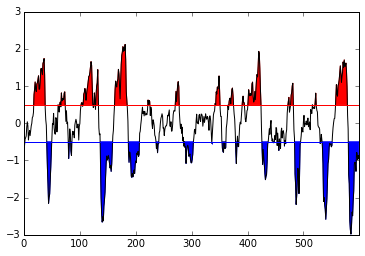

In [11]:
plt.clf()
xrange = np.arange(0,600)
y = enso_anomaly[600:1200]
x_limits = [min(xrange), max(xrange)]
y_limits = [-3.0, 3.0]
el_nino_threshold = 0.5
plt.xlim(x_limits)
plt.ylim(y_limits)
plt.plot(xrange, y,c='black')
plt.plot(x_limits, [el_nino_threshold, el_nino_threshold], c='r')
plt.plot(x_limits, [-el_nino_threshold, -el_nino_threshold], c='b')
plt.fill_between(xrange, el_nino_threshold, y, color='red', where=y>=el_nino_threshold, interpolate=True)
plt.fill_between(xrange, -el_nino_threshold, y, color='blue', where=y<=-el_nino_threshold)
plt.savefig("anomaly.png")

## Downsampling

In principle we could keep the full temperature map with its 55296 values, and let you take care of the sparsification and subsampling. We found that this would unnecessarily overwhelm the system (especially the memory), so we decided to downsample the temperature grid from a $1^\circ$ resolution to a $5^\circ$ resolution, using the pyresample package.

In [12]:
lat_bins = np.arange(-90,91,5, dtype=float)
lon_bins = np.arange(2.5,360,5, dtype=float)

In [13]:
lat_in, lon_in = np.meshgrid(temperatures_xray['lat'], temperatures_xray['lon'])
grid_in = pyresample.geometry.SwathDefinition(lats=lat_in, lons=lon_in - 180)
lat_out, lon_out = np.meshgrid(lat_bins, lon_bins)
grid_out = pyresample.geometry.SwathDefinition(lats=lat_out, lons=lon_out - 180)

The following cell will take some time.

In [14]:
resampled_tas = np.empty((temperatures_xray['tas'].shape[0], lat_bins.shape[0], 
                         lon_bins.shape[0]), dtype=float)
for t in range(temperatures_xray['tas'].shape[0]):
    print t
    resampled_tas[t] = pyresample.kd_tree.resample_nearest(
        grid_in, temperatures_xray['tas'][t].values.T, grid_out, 
        radius_of_influence=500000, fill_value=None).data.T

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [15]:
resampled_tas.shape

(6012, 37, 72)

In [16]:
resampled_xray = xray.Dataset(
    {'tas': (['time', 'lat', 'lon'], resampled_tas)},
    coords={'time': temperatures_xray['time'],
            'lat': lat_bins,
            'lon': lon_bins})

Alternatively, if you have saved the file below, you can reload it here.

In [17]:
#resampled_xray = xray.open_dataset(
#    'COLA_data/resampled_tas_Amon_CCSM4_piControl_r1i1p1_080001-130012.nc', decode_times=False)

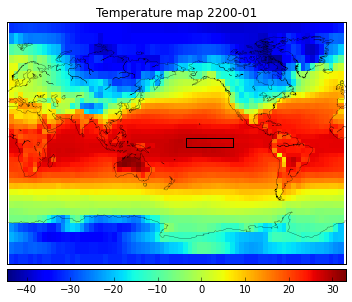

In [18]:
t = -12
plot_map(resampled_xray['tas'], t)

## The cross-validation object

Cross validating time-series predictors is tricky. We can't simply shuffle the observations $z_t =$ <code>temperatures_xray[t]</code> since we would lose both causality and the correlation structure that follows natural order. 

To formalize the issue, let us first define formally the predictor that we will produce in the RAMP. Let the time series be $z_1, \ldots, z_T$ and the let target to predict at time $t$ be $y_t$. The target is usually (and in our case) a function of the future $z_{t+1}, \ldots$, but it can be anything else. We want to learn a function that predicts $y$ from the past, that is

\begin{equation}
\hat{y}_t = f(z_1, ..., z_t) = f(Z_t)
\end{equation}

where $Z_t = (z_1, ..., z_t)$ is the past. Now, the sample $(Z_t, y_t)$ is a regular (although none iid) sample from the point of view of shuffling, so we can train on $\{Z_t, y_t\}_{t \in \cal{I}_{\text{train}}}$ and test on $(Z_t, y_t)_{t \in \cal{I}_{\text{test}}}$, where $\cal{I}_{\text{train}}$ and $\cal{I}_{\text{test}}$ are arbitrary but disjunct train and test index sets, respectively (typically produced by sklearn's <code>ShuffleSplit</code>).

The training algorithm thus maps $(Z_t, y_t)_{t \in \cal{I}_{\text{train}}}$ to $f$. The training $Z_t$s overlap, so basically the module will have to have access to all the data $Z_T$ and training labels $\{y_t\}_{t \in \cal{I}_{\text{train}}}$. You will have to be careful produce a predictor $f$ that of course can only use the past at test time.

To allow a reasonably long past before making the first prediction, we strip the first $b = 120$ months (burn-in). You can of course use a longer window in your feature extractor, but in this case you will have to handle the missing time points in the beginning of the sequence. We also cannot use the last six months since we don't have a target for these.

In [19]:
from sklearn.cross_validation import ShuffleSplit

random_state = 61
n_burn_in = 120
n_lookahead = 6
skf = ShuffleSplit(resampled_xray['time'].shape[0] - n_burn_in - n_lookahead, n_iter=2, 
                   test_size=0.5, random_state=random_state)

## The target

The goal is to predict the temperature in the El Nino region, $\ell = 6$ months ahead. For this we have to shift the enso vector by six months to the right, or equivalently, its time index by six months to the left. We then add the target as a new DataArray into the temperatures_xray Dataset, so the feature extractor can access it. The formal definition of the target is

\begin{equation}
  y_t = \frac{1}{D} \sum_{(lat, lon) \in \cal{A}_{\rm{El Nino}}} z_{t + \ell}^{(lat, lon)}
\end{equation}

Where $\cal{A}_{\rm{El Nino}} = \{(lat, lon) : -5^\circ < lat < 5^\circ \wedge -170^\circ < lon < -120^\circ\}$ is the index set El Nino 3.4 region, $D$ is the number of temperature measurements in the region, and $z_t^{(lat, lon)}$ is the temperature measured at time $t$, longitude $lon$ and latitude $lat$. 

If you reloaded <code>resampled_xray</code> above, don't execute this (<code>resampled_xray</code> contains the target).

In [20]:
target = enso.copy(deep=True)
target['time'] = np.roll(target['time'], n_lookahead)
target[:n_lookahead] = np.NaN
resampled_xray['target'] = target

In [21]:
resampled_xray

<xray.Dataset>
Dimensions:  (lat: 37, lon: 72, time: 6012)
Coordinates:
  * lat      (lat) float64 -90.0 -85.0 -80.0 -75.0 -70.0 -65.0 -60.0 -55.0 ...
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 27.5 32.5 37.5 42.5 47.5 ...
    height   float64 2.0
  * time     (time) datetime64[ns] 1700-01-16 1700-02-13 1700-03-16 ...
Data variables:
    tas      (time, lat, lon) float64 244.6 244.5 244.6 244.2 244.5 244.4 ...
    target   (time) float64 299.1 298.6 298.2 298.3 298.7 298.9 299.3 299.7 ...

You can save <code>resampled_xray</code> here.

In [22]:
#resampled_xray.to_netcdf('COLA_data/resampled_tas_Amon_CCSM4_piControl_r1i1p1_080001-130012.nc')
#resampled_xray.to_netcdf('COLA_data/resampled_tas_Amon_CCSM4_piControl_r2i1p1_095301-110812.nc')
#resampled_xray.to_netcdf('COLA_data/resampled_tas_Amon_CCSM4_piControl_r3i1p1_000101-012012.nc')

<code>valid_range</code> is the index set that indicates the time points where a prediction should be made. <code>y</code> is the set of targets in this range (reshaped as a single-column matrix for satisfying sklearn).

In [23]:
valid_range = range(n_burn_in, resampled_xray['time'].shape[0] - n_lookahead)
y = resampled_xray['target'][valid_range].values

The following shows that the target varies around its mean at about $0.98^\circ$C, which is a thus a rough upper bound on the score of the simplest predictor.

298.904664817
0.978568394495


(array([    4.,    15.,    66.,   219.,   559.,  1159.,  1661.,  1448.,
          632.,   123.]),
 array([ 294.38264361,  295.08209072,  295.78153783,  296.48098494,
         297.18043205,  297.87987917,  298.57932628,  299.27877339,
         299.9782205 ,  300.67766761,  301.37711472]),
 <a list of 10 Patch objects>)

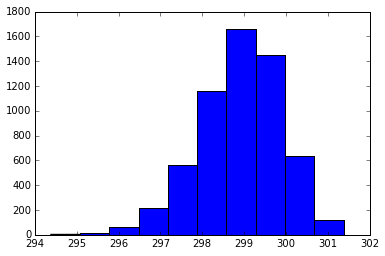

In [24]:
print y.mean()
print y.std()
plt.hist(y)

To make a tighter upper bound, let's look at the standard deviation of the seasonally adjusted temperature.

-2.50557318665e-15
0.891192110179


(array([    9.,    28.,   133.,   348.,   863.,  1700.,  1761.,   775.,
          341.,    54.]),
 array([-3.81771014, -3.17149164, -2.52527314, -1.87905464, -1.23283614,
        -0.58661764,  0.05960086,  0.70581936,  1.35203786,  1.99825636,
         2.64447486]),
 <a list of 10 Patch objects>)

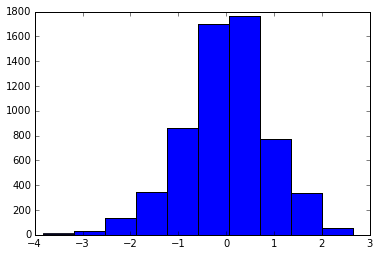

In [25]:
print enso_anomaly.values.mean()
print enso_anomaly.values.std()
plt.hist(enso_anomaly)

## The pipeline

We have factorized the pipeline into two steps. The first feature extractor $g$ transforms the past into a classical feature vector $x_t = g(Z_t)$, and the classical regressor $h$ predicts the target from the feature vector $\hat{y}_t = h(x_t)$. To summarize, the full predictor is a composition $f(Z_t) = h(g(Z_t))$. If you have a complex solution where this factorization does not make sense, you can do all the work in the feature extractor, output a prediction $x_t$ into a single-column feature matrix, and then use an identity regressor $\hat{y}_t = x_t$ in the regressor module. This setup cannot handle sophisticated techniques that do not separate feature extraction from regression (like RNNs), but it is a fundamental issue (we do not know how to bag an RNN).

### The feature extractor

The feature extractor implements a single <code>transform</code> function. As we explained above, it receives the full <code>temperatures_xray</code>, the length of the burn-in period $b$, the look-ahead $\ell$, and the CV object <code>skf_is = (train_is, test_is)</code>. It should produce a feature matrix of length $T - b - \ell$ representing the past vector $(Z_{t+b}, \ldots, Z_{T-\ell})$. For constructing/computing $x_t$, it can only use the past $Z_t = (z_1, \ldots, z_t) = $ <code>temperatures_xray['tas'][:t]</code>.


You can choose one of the example feature extractors and copy-paste it into your ts_feature_extractor.py file. Comments within the cells explain what they do. 

In [26]:
import numpy as np

en_lat_bottom = -5
en_lat_top = 5
en_lon_left = 360 - 170
en_lon_right = 360 - 120

def get_area_mean(tas, lat_bottom, lat_top, lon_left, lon_right):
    """The array of mean temperatures in a region at all time points."""
    return tas.loc[:, lat_bottom:lat_top, lon_left:lon_right].mean(dim=('lat','lon'))

def get_enso_mean(tas):
    """The array of mean temperatures in the El Nino 3.4 region at all time points."""
    return get_area_mean(tas, en_lat_bottom, en_lat_top, en_lon_left, en_lon_right)

class FeatureExtractor(object):

    def __init__(self):
        pass

    def transform(self, temperatures_xray, n_burn_in, n_lookahead, skf_is):
        """Compute the single variable of mean temperatures in the El Nino 3.4 
        region."""
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning and the prediction look-ahead from
        # the end.
        valid_range = range(n_burn_in, temperatures_xray['time'].shape[0] - n_lookahead)
        enso = get_enso_mean(temperatures_xray['tas'])
        enso_valid = enso.values[valid_range]
        X = enso_valid.reshape((enso_valid.shape[0], 1))
        return X

In [27]:
import numpy as np

en_lat_bottom = -5
en_lat_top = 5
en_lon_left = 360 - 170
en_lon_right = 360 - 120

def get_enso_mean(tas):
    """The array of mean temperatures in the El Nino 3.4 region at all time points."""
    return tas.loc[:, en_lat_bottom:en_lat_top, en_lon_left:en_lon_right].mean(dim=('lat','lon'))

class FeatureExtractor(object):

    def __init__(self):
        pass

    def fit(self, temperatures_xray, n_burn_in, n_lookahead):
        pass

    def transform(self, temperatures_xray, n_burn_in, n_lookahead, skf_is):
        """Compute the single variable of montly means corresponding to the  temperatures in the El Nino 3.4 
        region."""
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning and the prediction look-ahead from
        # the end.
        valid_range = range(n_burn_in, temperatures_xray['time'].shape[0] - n_lookahead)
        enso = get_enso_mean(temperatures_xray['tas'])
        # reshape the vector into a table years as rows, months as columns
        enso_matrix = enso.values.reshape((-1,12))
        count_matrix = np.ones(enso_matrix.shape)
        # compute cumulative means of columns (remember that you can only use
        # the past at each time point) and reshape it into a vector
        enso_monthly_mean = (enso_matrix.cumsum(axis=0) / count_matrix.cumsum(axis=0)).ravel()
        # roll it backwards (6 months) so it corresponds to the month of the target
        enso_monthly_mean_rolled = np.roll(enso_monthly_mean, n_lookahead - 12)
        # select valid range
        enso_monthly_mean_valid = enso_monthly_mean_rolled[valid_range]
        # reshape it into a matrix of a single column
        X = enso_monthly_mean_valid.reshape((enso_monthly_mean_valid.shape[0], 1))
        return X

In [28]:
import numpy as np

en_lat_bottom = -5
en_lat_top = 5
en_lon_left = 360 - 170
en_lon_right = 360 - 120

def get_enso_mean(tas):
    """The array of mean temperatures in the El Nino 3.4 region at all time points."""
    return tas.loc[:, en_lat_bottom:en_lat_top, en_lon_left:en_lon_right].mean(dim=('lat','lon'))

class FeatureExtractor(object):

    def __init__(self):
        pass

    def fit(self, temperatures_xray, n_burn_in, n_lookahead):
        pass

    def transform(self, temperatures_xray, n_burn_in, n_lookahead, skf_is):
        """Combine two variables: the montly means corresponding to the month of the target and 
        the current mean temperature in the El Nino 3.4 region."""
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning and the prediction look-ahead from
        # the end.
        valid_range = range(n_burn_in, temperatures_xray['time'].shape[0] - n_lookahead)
        enso = get_enso_mean(temperatures_xray['tas'])
        # reshape the vector into a table years as rows, months as columns
        enso_matrix = enso.values.reshape((-1,12))
        count_matrix = np.ones(enso_matrix.shape)
        # compute cumulative means of columns (remember that you can only use
        # the past at each time point) and reshape it into a vector
        enso_monthly_mean = (enso_matrix.cumsum(axis=0) / count_matrix.cumsum(axis=0)).ravel()
        # roll it backwards (6 months) so it corresponds to the month of the target
        enso_monthly_mean_rolled = np.roll(enso_monthly_mean, n_lookahead - 12)
        # select valid range
        enso_monthly_mean_valid = enso_monthly_mean_rolled[valid_range]
        enso_valid = enso.values[valid_range]
        X = np.array([enso_valid, enso_monthly_mean_valid]).T
        return X

In [33]:
class FeatureExtractor(object):
 
    def __init__(self):
        pass
 
    def fit(self, temperatures_xray, n_burn_in, n_lookahead):
        pass
 
    def transform(self, temperatures_xray, n_burn_in, n_lookahead, skf_is):
        """Use world temps as features."""        
        # Set all temps on world map as features
        all_temps = temperatures_xray['tas'].values
        time_steps, lats, lons = all_temps.shape
        all_temps = all_temps.reshape((time_steps,lats*lons))
        all_temps = all_temps[n_burn_in:-n_lookahead,:]
        time_steps, temps = all_temps.shape
 
        data = []
        lag = 0
        if lag == 0:
            temp_list = np.zeros((time_steps,temps))
            for i in range(0,time_steps):
                temp_list[i,:] = all_temps[i,:]
        else:
            temp_list = np.zeros((time_steps-lag,(lag+1)*temps))
            for i in range(lag,time_steps):
                temp_list[i-lag,:] = all_temps[i-lag:i+1,:].reshape(((lag+1)*temps))
 
        data.append(temp_list)
                
        return data[0]

### The regressor

The regressor should implement an sklearn-like regressor with fit and predict functions. Let's start with two simple regressors, a linear regressor and a regression tree. You can copy paste either of these into your first regressor.py file.

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator

class Regressor(BaseEstimator):
    def __init__(self):
        self.clf = LinearRegression()

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

In [30]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator

class Regressor(BaseEstimator):
    def __init__(self):
        self.clf = DecisionTreeRegressor(max_depth=5)

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator

class Regressor(BaseEstimator):
    def __init__(self):
        self.clf = DecisionTreeRegressor(max_depth=5)

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

### Unit test

This cell unit-tests your selected regressor and feature extractor and prints the RMSE.

In [ ]:
valid_range = range(n_burn_in, resampled_xray['time'].shape[0] - n_lookahead)
y_array = resampled_xray['target'][valid_range].values
y = y_array.reshape((y_array.shape[0], 1))
fe = FeatureExtractor()
X = fe.transform(resampled_xray, n_burn_in, n_lookahead, list(skf)[0])
reg = Regressor()
scores = np.sqrt(-cross_val_score(reg, X=X, y=y, scoring='mean_squared_error', cv=skf))
print scores.mean()

## Submission

For submitting your code, first create a git repo and enter its public address (https://...) at the submission site. Place your to files <code>regressor.py</code>, and <code>ts_feature_extractor.py</code> in the git repo, and then run the following sequence.

<code>
git add regressor.py ts_feature_extractor.py
git commit -m "my commit log"
git tag model_description
git push origin master --tags
</code>

We will fetch your submission. At this point it will appear in the "New models" table. Once it is trained, it will either be added to the leaderboards, or it will appear in the "Failed models" table. Clicking on “error” will bring you to the error that python threw.

### Deleting failed models

You cannot delete models once they appear in the leaderboard. However, you can delete failed models by executing the following sequence:

<code>
git tag -d model_description
git push origin :refs/tags/model_description
</code>

The first command deletes your local tag and the second command deletes the remote tag. When we fetch next time, the model will disappear from the table. You can then reuse the tag to resubmit another model.